Word2vec -- final algorithm 
-------------------
- This solution is based on Tomas Mikolov's word2vec algorithm used for generating vectors for words given some corpus of text, basic idea is that similar words have similar vectors 
- For more information on this original algorithm see nice explanation here https://www.tensorflow.org/tutorials/word2vec 
- For use in natural language the algorithm needs just the words and definition of context, that can be for example the two surrounding words in the text corpus 
- First it is important to note that we DO NOT use any text information about products, instead of corpus of text we fed corpus of items (for the algorithm item can be string, number, hash -- basically anything that corresponds uniquely to one mall.cz product) and we defined that context of one item are other items that one user viewed in one visit -- so the ONLY thing that we exploit are the groupings of items into visits
- This approach offers great flexibility in both fitting the model (different definitions of context) and making the prediction (we can take products the user viewed long ago with smaller weights etc.)

In [1]:
## General libraries
import numpy as np
import tensorflow as tf
import pandas as pd
import collections
import math
import pprint
import pickle

## My libraries 
import comms

In [2]:
## Optimization Settings  
counts_alg = "A"
genbatch_alg = "A"
batch_size = 32
embedding_size = 32
num_sampled = 16
num_iter = 50000

** Load and format data to sessions and make test and train set **

In [3]:
date_bags_train, word_bags_train, context_ids_train = pickle.load( open( "train_sessions.pkl", "rb" ) )
date_bags_test, word_bags_test, context_ids_test = pickle.load( open( "test_sessions.pkl", "rb" ) )

In [4]:
bots = ["0412468358e09411dfbabeed26fce809", "d0ef1e7d53b869c477dbbd4ec6cbc46d"]
word_bags_train = [wbt for wbt,ctx in zip(word_bags_train, context_ids_train) if ctx not in bots]

** Generate data for training the model **

In [6]:
## 1) context == all data of one user 
# word_bags_all_per_user = [[w for wb in word_bag for w in wb] for word_bag in word_bags_train] ## np.sum(np.array([len(w)<2 for w in word_bags_all_per_user]))

## 2) context = one user visit
word_bags_all_per_sess = [wb for word_bag in word_bags_train for wb in word_bag]
word_bags_all_per_sess = [wb for wb in word_bags_all_per_sess if len(wb) >= 2] ## np.sum(np.array([len(x)<2 for x in word_bags_all_per_sess]))

** Generate dictionary and batch generating function **

In [7]:
dictionary, reversed_dictionary = comms.create_dictionary(word_bags_all_per_sess, counts_alg)

## Number of distinct words in vocabulary
vocabulary_size = len(dictionary)

genbatch_prereq = comms.create_genbatch_prerequisities(word_bags_all_per_sess, dictionary)

def generate_batch(batch_size): 
    return comms.generate_batch(batch_size, genbatch_prereq, genbatch_alg) 

** Build model and train the shit out of it **

In [8]:
w2v_model = comms.create_w2v_tf_model(batch_size, embedding_size, vocabulary_size, num_sampled, learn_rate = 1.0)
train_inputs, train_labels, embeddings, nce_weights, nce_biases, loss, optimizer, init = w2v_model

In [9]:
sess = tf.Session()
sess.run(init)

In [10]:
## Learn the embeddings
for i in range(num_iter): 
    batch, labels = generate_batch(batch_size)
    _, loss_eval = sess.run([optimizer, loss], {train_inputs : batch, train_labels : labels})
    if i % 1000 == 0: 
        print("Loss at iteration",i, " : ",loss_eval)

Loss at iteration 0  :  47.9549
Loss at iteration 1000  :  7.3356
Loss at iteration 2000  :  3.35014
Loss at iteration 3000  :  2.40287
Loss at iteration 4000  :  2.31406
Loss at iteration 5000  :  2.87321
Loss at iteration 6000  :  2.14625
Loss at iteration 7000  :  1.88034
Loss at iteration 8000  :  1.82349
Loss at iteration 9000  :  1.35073
Loss at iteration 10000  :  2.17591
Loss at iteration 11000  :  1.66834
Loss at iteration 12000  :  1.97547
Loss at iteration 13000  :  1.65538
Loss at iteration 14000  :  2.05232
Loss at iteration 15000  :  1.42181
Loss at iteration 16000  :  1.5521
Loss at iteration 17000  :  1.53365
Loss at iteration 18000  :  1.21607
Loss at iteration 19000  :  1.25526
Loss at iteration 20000  :  1.65938
Loss at iteration 21000  :  1.9944
Loss at iteration 22000  :  1.19195
Loss at iteration 23000  :  1.32677
Loss at iteration 24000  :  1.43273
Loss at iteration 25000  :  2.31923
Loss at iteration 26000  :  2.38598
Loss at iteration 27000  :  1.38105
Loss at 

In [11]:
embeddings_eval, nce_weights_eval, nce_biases_eval = sess.run([embeddings, nce_weights, nce_biases]) 

In [12]:
model_packed = embeddings_eval, nce_weights_eval, nce_biases_eval, dictionary, reversed_dictionary
pickle.dump(model_packed, open("model_packed.pkl", "wb"))

** Test that shit **

** Eval whole user history **

In [13]:
wb_two_sess = [wb for wb in word_bags_test if len(wb)>=2]
wb_test_flat = [[w for wb in word_bag for w in wb] for word_bag in word_bags_test]  ## np.sum(np.array([len(x)<2 for x in wb_test_flat])) 

In [14]:
def pred_order(ind_list):
    """
    Order in which we will present item i to the user 
    
    Arguments:
    ind_list -- indices of items according to dictionary
    
    Return:
    order_presented -- vector of shape (embeddings.shape[0], ), ith entry is order in which we present ith item
    """
    mean_emb = np.mean(embeddings_eval[ind_list,:], axis=0)
    preferences = comms.softmax(np.sum(nce_weights_eval * mean_emb, axis=1) + nce_biases_eval)
    order_presented = len(preferences) - np.argsort(np.argsort(preferences)) 
    return order_presented

In [15]:
def eval_one_sess(sess, naive=False): 
    """
    sess -- list of item ids
    naive -- use naive approach for defining order, we present items that were already selected
             returns order 1 if predicted item is in past items
             returns 1000 if predicted item is not in past items
    
    """
    ind = [dictionary.get(s) for s in sess]
    ind = [i for i in ind if i != None]
    if len(ind) == 0:
        return []
    else: 
        sess_orders = []
        for j in range(1, len(ind)-1):
            if naive: 
                sess_orders.append(1 if ind[j] in ind[0:j] else 1000)
            else:
                sess_orders.append(pred_order(ind[0:j])[ind[j]])
#                 sess_orders.append(list(np.random.choice(2007,2007, replace=False))[ind[j]]) ## stupid approach 

    return sess_orders

In [20]:
nai = False ## this switches between naive and our approach, the approach that mall uses can be switched on uncommenting one line in the function eval_one_sess 
evals_for_flat_users = [eval_one_sess(s, naive=nai) for s in wb_test_flat]
print("Number of testing users: ", len(evals_for_flat_users))
print("Number of testing users, where prediction available:", np.sum(np.array([len(x) > 0 for x in evals_for_flat_users])))
median_evals_for_flat_users = [np.median(e) for e in evals_for_flat_users if len(e) > 0]
percentile_evals_for_flat_users = [np.percentile(e,90) for e in evals_for_flat_users if len(e) > 0]
print("Number of users that had more than half of their predictions on first page: ", np.sum(np.array([e <= 48 for e in median_evals_for_flat_users])))
print("Number of users that had more than 90% of their predictions on first page: ", np.sum(np.array([e <= 48 for e in percentile_evals_for_flat_users])))

Number of testing users:  500
Number of testing users, where prediction available: 284
Number of users that had more than half of their predictions on first page:  223
Number of users that had more than 90% of their predictions on first page:  188


In [18]:
## Procento produktu co se zobrazi uzivateli na prvni strance 
percent_good_experience = np.mean([np.mean([e<48 for e in eval]) for eval in evals_for_flat_users if len(eval)>0])
print("Percent of users with good experience w2v: ", percent_good_experience)

Percent of users with good experience w2v:  0.777758009579


In [21]:
import matplotlib.pyplot as plt

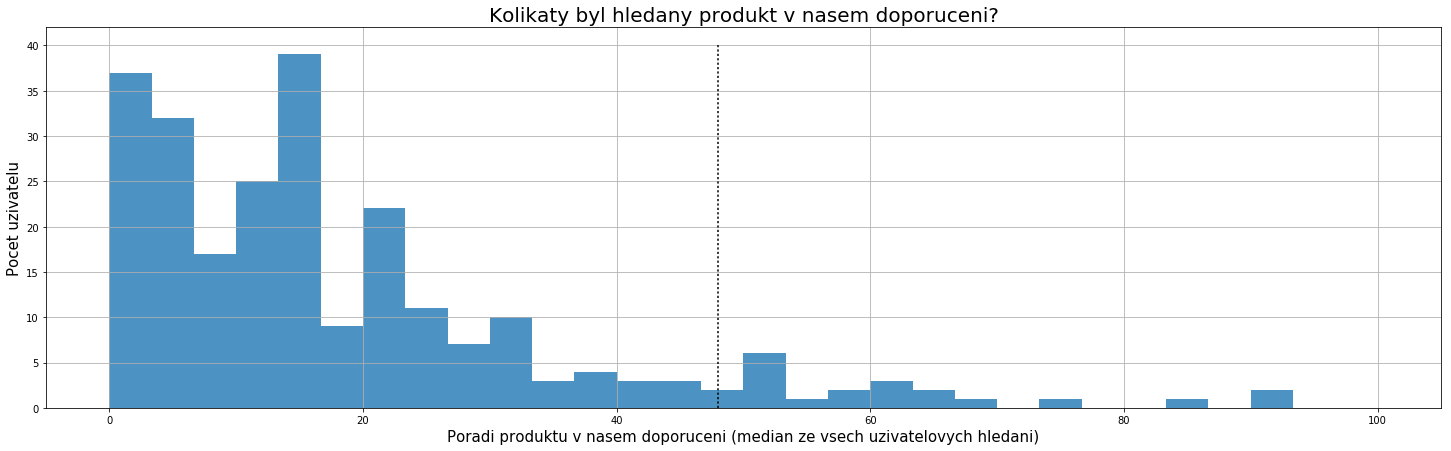

In [23]:
plt.figure(figsize=(25,7))
plt.hist(median_evals_for_flat_users, range=[0,100], alpha=0.8, bins=30)
plt.title("Kolikaty byl hledany produkt v nasem doporuceni?", size = 20)
plt.xlabel("Poradi produktu v nasem doporuceni (median ze vsech uzivatelovych hledani)", size= 15)
plt.ylabel("Pocet uzivatelu", size = 15)
plt.vlines(x=48, ymin=0, ymax=40, linestyles="dotted")
plt.grid()
plt.show()

** The following are some additional evaluation metrics we used **

** Eval new session **

In [ ]:
predictive_sess = [[dictionary.get(w) for ww in wb[:-1] for w in ww] for wb in wb_two_sess]
target_sess = [[dictionary.get(x) for x in wb[-1]] for wb in wb_two_sess]

In [ ]:
target_sess

In [ ]:
next_sess_predictions = [list(pred_order(predictive_sess[i])[target_sess[i]]) for i in range(len(predictive_sess))]

In [ ]:
## naivni pristup 
next_sess_predictions = [ np.mean([1 if t in ps else 0 for t in trg]) for trg, ps in zip(target_sess, predictive_sess) ]

In [ ]:
np.mean(next_sess_predictions)

In [ ]:
np.mean([np.mean([x <= 48 for x in wb]) for wb in next_sess_predictions])

** Eval EACH session **

In [ ]:
wb_two_sess = [wb for wb in word_bags_test if len(wb)>=2]
wb_two_sess = [[w for w in word_bag if len(w)>1] for word_bag in wb_two_sess]
wb_two_sess = [wb for wb in wb_two_sess if len(wb)>0]
wb_two_flat = [w for wb in wb_two_sess for w in wb]
wb_two_its = [[dictionary.get(w) for w in wb] for wb in wb_two_flat] 
wb_two_its = [[w for w in wb if w!=None] for wb in wb_two_its]

In [ ]:
def eval_one(ind, naive=False): 
    sess_orders = []
    for j in range(1, len(ind)):
        if naive: 
            sess_orders.append(1 if ind[j] in ind[0:j] else 1000)
        else:
            sess_orders.append(pred_order(ind[0:j])[ind[j]])
    return sess_orders

In [ ]:
wb_two_ords = [eval_one(w) for w in wb_two_its]

In [ ]:
np.sum(np.array([np.median(w)<=48 for w in wb_two_ords])) / len(wb_two_ords)